### **Long Short Term Memory**

In [ ]:
#Initially we download the zipped data

import os 
if not os.path.isfile('data.zip'):
    !wget https://github.com/LeonardoBerti07/Deep-Learning-Algorithms-for-financial-time-serie-modeling-/blob/main/Datasets/DB2.zip
    !unzip -n data.zip
    print('data downloaded.')
else:
    print('data already existed.')

In [ ]:
#Load packages
from faulthandler import dump_traceback
import time
import datetime
from unicodedata import name
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms  
from torch import nn
from google.colab import drive
import random
from sklearn.metrics import accuracy_score, classification_report

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Data**
The dataset in the folder Dataset is the LOBSTER dataset zipped and normalized. I have combined the data of the 5 stocks available for free. I used the version with 10 levels, so we have 40 columns, in fact for every level we have a quadruple wiht the ask and bid prices and with the volumes associated, for more information i reference to the thesis. 

I used 70% to do the training, 15% to do the validation and 15% for the testing.

In [ ]:
# please change the data_path to your local path

num_classes = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_path = "/DB2.npy"


dec = np.load(data_path)

train_size = int(0.70 * dec.shape[0])
val_size = int(0.15 * dec.shape[0])
test_size = val_size

dec_train = dec[:train_size]
dec_val = dec[train_size:val_size+train_size]
dec_test = dec[val_size+train_size:]

(1477602, 40)


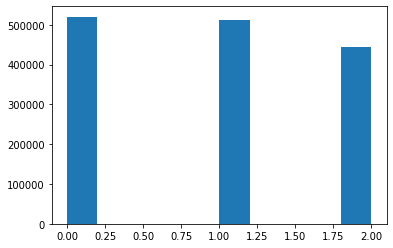

(316629, 40)


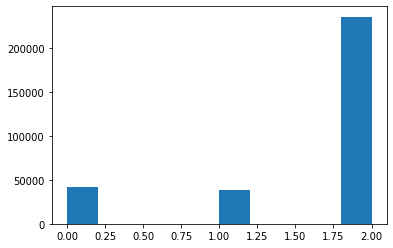

(316629, 40)


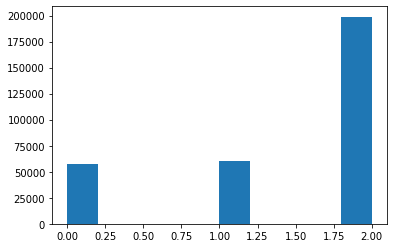

In [ ]:

#Hyperparameters
epochs = 50
lr = 0.00005
regularization = 0.5

    #input shape 
sequence_length = 50   #each sequence is composed by 5 day
batch_size = 64
num_features = 40

    #hidden shape
num_layer = 1
hidden_size = 64

#Create Sequences for the LSTM
def create_sequences(input_data, seq_len):
    sequences = []
    data_size = input_data.shape[0]
    Y = []
    print(input_data.shape)
    alpha = 0.0007226735755120588
    for i in range(data_size - 2*seq_len):
        sequence = input_data[i:i+seq_len, :]
        label_position = i + seq_len             
        ask_minus = sequence[:, :1]
        bid_minus = sequence[:, 2:3]
        ask_plus = input_data[(i+seq_len):(i+2*seq_len), :1]
        bid_plus = input_data[(i+seq_len):i+2*seq_len, 2:3]
        m_minus = (ask_minus + bid_minus) / 2
        m_minus = np.sum(m_minus) / seq_len
        m_plus = (ask_plus + bid_plus) / 2
        m_plus = np.sum(m_plus) / seq_len
        #print((m_plus - m_minus) / m_minus)
        if (m_plus - m_minus) / m_minus < -alpha:
          label = 1
        elif (m_plus - m_minus) / m_minus > alpha:
          label = 0
        else:
          label = 2          
        Y.append(label)
        sequences.append((sequence, label))
        
    plt.hist(Y)
    plt.show()
    return sequences

train_sequences = create_sequences(dec_train, sequence_length)
test_sequences = create_sequences(dec_test, sequence_length)
val_sequences = create_sequences(dec_val, sequence_length)

In [ ]:
#Create the Dataset
class Dataset(Dataset):
    def __init__(self, sequences):  
        self.sequences = sequences

    def __len__(self):    #return the len of the dataste
        return len(self.sequences)

    def __getitem__(self, idx):  #idx is the index of the sequence that we want to load
        sequence, label = self.sequences[idx]

        return dict(
            sequence = torch.from_numpy(sequence).float(),
            label = label
        )

In [ ]:
#Create the DataLoader
class PriceDataModule():
    def __init__(self, train_sequences, val_sequences, test_sequences, num_workers=1, batch_size = 8):
        super().__init__()
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.val_sequences = val_sequences
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage=None):        
        self.train_dataset = Dataset(self.train_sequences)
        self.test_dataset = Dataset(self.test_sequences)
        self.val_dataset = Dataset(self.val_sequences)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size = self.batch_size,
            shuffle = True,
            num_workers=self.num_workers
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size = self.batch_size,
            shuffle = False,
            num_workers=self.num_workers
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = self.batch_size,
            shuffle = False,
            num_workers=self.num_workers
        )

data_module = PriceDataModule(train_sequences, val_sequences, test_sequences, 2, batch_size)
data_module.setup()
train_dataloader = data_module.train_dataloader()
test_dataloader = data_module.test_dataloader()
val_dataloader = data_module.val_dataloader()

### **Model Architecture**
The architecture has a single layer and a hidden size of 64. The reason for the simplicity of the architecture is that with a greater amount of layers and a greater hidden size the model tends to go in overfitting. As for the hyperparameters, the dropout is equal to 0.5 (to avoid overfitting as much as possible), the learning rate at 0.00005, the batch size is 64. The model has a total of 27,587 parameters.

In [ ]:
#Create the LSTM model
class myLSTM(nn.Module):
    def __init__(self, n_features, num_classes, dropout, n_hidden, n_layers):
        super().__init__()
        self.lstm = nn.LSTM(
        input_size = n_features,
        hidden_size = n_hidden,
        batch_first = True,
        num_layers = n_layers, # Stack LSTMs
        dropout = dropout       
    )
        self.classifier = nn.Linear(n_hidden, num_classes) #after we have analyze the sequence, now we have to perform the classification, we utilize a classic linear layer
        
    def forward(self, x):
        self.lstm.flatten_parameters()  
        #x shape is (batch_size, seq_len, n_features)

        output, (hidden, _) = self.lstm(x)
        out = hidden[-1]  #We want the output from the last layer of the last time step to go into the final regressor linear layer, we don't use output 
                          #because in the output there are the H_t for each time step from the last layer, so the dim is (batch_size, L, Hidden_size)
                          #instead in hidden there are hidden state for every layer but only for the last time step, so the dim is (num_layer, Hidden_size) 
                          #so if batch_size=1, the last array of output = hidden[-1]
      
        return self.classifier(out)

model = myLSTM(num_features, num_classes, regularization, hidden_size, num_layer).to(device)
model.float()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr) 



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


### **Model Training**

In [ ]:
#Training the model
def trainingLoop(train_dataloader, model, loss_fn, optimizer):
    cont = 0
    train_loss = 0
    for batch in train_dataloader:         #scorriamo i vari batch del data set, in batch c'è l'index
        sequences = batch["sequence"].to(device)
        labels = batch["label"].to(device)
        #forward pass
        outputs = model(sequences)            #we do the prediction
        loss = loss_fn(outputs, labels)     #compute the error
        train_loss += loss
        #backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cont+=1

    train_loss = train_loss / cont   #we compute the average train loss
    print()
    print(train_loss) 

### **Model Testing**

In [ ]:
#Testing 
def testLoop(test_dataloader, model, loss_fn, test_size):
    true = [0, 0, 0]
    denom = [0, 0, 0, 0, 0, 0]
    num_batches = len(test_dataloader)
    test_loss = 0
    correct = 0

    with torch.no_grad():      
        for batch in test_dataloader:         #we scroll through the various batches of the data set
            sequences = batch["sequence"].to(device)
            labels = batch["label"].to(device)
   
            outputs = model(sequences)            #we do the prediction
            predicted = outputs.argmax(1)
            
            test_loss += loss_fn(outputs, labels).item()       
            correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()     #we count the correct ones
            
            for i in range(labels.size(dim=0)):   #compute the data to calculate precision and recall
              if (labels[i] == predicted[i] == 0):
                true[0] += 1
                denom[0] += 1
                denom[1] += 1
              elif (labels[i] == predicted[i] == 1):
                true[1] += 1
                denom[2] += 1
                denom[3] += 1
              elif (labels[i] == predicted[i] == 2):
                true[2] += 1
                denom[4] += 1
                denom[5] += 1
              elif (labels[i] == 0 and predicted[i] == 1):
                denom[1] += 1
                denom[2] += 1
              elif (labels[i] == 0 and predicted[i] == 2):
                denom[1] += 1
                denom[4] += 1
              elif (labels[i] == 1 and predicted[i] == 0):
                denom[3] += 1
                denom[0] += 1
              elif (labels[i] == 1 and predicted[i] == 2):
                denom[3] += 1
                denom[4] += 1
              elif (labels[i] == 2 and predicted[i] == 0):
                denom[5] += 1
                denom[0] += 1
              elif (labels[i] == 2 and predicted[i] == 1):
                denom[5] += 1
                denom[2] += 1

        test_loss = test_loss / num_batches        #average loss 
        correct = correct / test_size
        if (denom[1] != 0):
          recallUp = true[0] / denom[1]
        else:
          recallUp = 0

        if (denom[3] != 0):
          recallDown = true[1] / denom[3]
        else:
          recallDown = 0  

        if (denom[5] != 0):
          recallNo = true[2] / denom[5]
        else:
          recallNo = 0

        if (denom[0] != 0):
          precisionUp = true[0] / denom[0]
        else:
          precisionUp = 0

        if (denom[2] != 0):
          precisionDown = true[1] / denom[2]
        else:
          precisionDown = 0

        if (denom[4] != 0):
          precisionNo = true[2] / denom[4]
        else:
          precisionNo = 0

        print(f"Accuracy: {correct * 100}, Average loss: {test_loss}")
        print(f"Precision Up: {precisionUp * 100}, Recall Up: {recallUp* 100}")
        print(f"Precision Down: {precisionDown* 100}, Recall Down: {recallDown* 100}")
        print(f"Precision No: {precisionNo* 100}, Recall No: {recallNo* 100}")
    return test_loss


In [ ]:
print("------- List Hyper Parameters -------")
print("epochs   ->   " + str(epochs))
print("learningRate   ->   " + str(lr))
print("dropout   ->   " + str(regularization))
print("training range   ->   " + str(train_size))
print("number of layer   ->    " + str(num_layer))
print("sequence length    ->     " + str(sequence_length))
print("hidden size    ->    " + str(hidden_size))


best_test_loss = 99999
best_val_loss = 99999
for e in range(epochs):       
    print("------------Start of Epoch {}/{}------------".format(e, epochs-1))
    #training
    trainingLoop(train_dataloader, model, loss_fn, optimizer)

    #validation
    val_loss = testLoop(val_dataloader, model, loss_fn, val_size)
    if (val_loss < best_test_loss):   #we save the best model
      torch.save(model, 'best_model_LSTM')
      best_test_loss = val_loss
      best_test_epoch = e
      print('model saved')      
    print("------------End of Epoch {}/{}------------".format(e, epochs-1))




------- List Hyper Parameters -------
epochs   ->   50
learningRate   ->   5e-05
dropout   ->   0.5
training range   ->   1477602
number of layer   ->    1
sequence length    ->     50
hidden size    ->    64
------------Start of Epoch 0/49------------


In [ ]:
model = torch.load('/best_model_LSTM')

#final test
testLoop(test_dataloader, model, loss_fn, test_size)
